In [123]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt

In [124]:
game_states = list( pickle.load( open( "game_states.p", "rb" ) ) )

In [125]:
boards = list(zip(*game_states))[0]
labels = list(zip(*game_states))[1]

In [126]:
def preprocess_boards(boards,rows = 6,columns = 7, mark = 1):
    
    boards = torch.FloatTensor(boards)
    num_boards = boards.shape[0]
    
    my_marks = boards == mark
    my_marks = my_marks.float()
    
    opp_marks = torch.mul(boards != mark, boards >0)
    opp_marks = -1*opp_marks.float()
    
    training_boards = torch.reshape( torch.cat((my_marks, opp_marks), 1), (-1,2,rows, columns) )
    
    return training_boards

def preprocess_labels(labels):
    
    labels = torch.Tensor(labels).long()
    
    y = torch.zeros((labels.shape[0],3))
    y[torch.arange(labels.shape[0]), labels] = 1.0
    
    
    return y
    
X = preprocess_boards(boards)
y = preprocess_labels(labels)
X_f = torch.flip(X,dims = [3])

X = torch.cat((X,X_f),0)
y = torch.cat((y,y),0)

In [149]:
class ConnectNet4(torch.nn.Module):
    #set learning rate to 1e-2
    #512 batch
    def __init__(self):
        
        super(ConnectNet4, self).__init__()
        
        self.features = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels = 2, out_channels = 128, kernel_size = 3, padding = 1), 
                        torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2, stride = 2),
                        torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2, padding = (0,1)), 
                        torch.nn.MaxPool2d(kernel_size = (2,4))
                        )
        
        self.classifier = torch.nn.Sequential(
                        torch.nn.Linear(128,128),
                        torch.nn.ReLU(),
                        torch.nn.Linear(128, 3),
                        torch.nn.Softmax(dim = 1)
                        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.reshape(x,[-1,128])
        x = self.classifier(x)
        
        return x

class ConnectNetX(torch.nn.Module):
    #set learning rate to 1e-2
    #512 batch
    def __init__(self):
        
        super(ConnectNet4, self).__init__()
        
        self.features = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels = 2, out_channels = 128, kernel_size = 4, padding = 1), 
                        torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2, stride = 2),
                        torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 2, padding = (0,1)), 
                        torch.nn.MaxPool2d(kernel_size = (1,4))
                        )
        
        self.classifier = torch.nn.Sequential(
                        torch.nn.Linear(256,128),
                        torch.nn.ReLU(),
                        torch.nn.Linear(128, 3),
                        torch.nn.Softmax(dim = 1)
                        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.reshape(x,[-1,256])
        x = self.classifier(x)
        
        return x

class ConnectNet5(torch.nn.Module):
    # set learning rate to 1e-3
    # 256 batch 
    def __init__(self):
        
        super(ConnectNet5, self).__init__()
        
        self.features = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels = 2, out_channels = 64, kernel_size = 5, padding = 2),
                        torch.nn.MaxPool2d(kernel_size = 2, stride=1),
                        torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (2,3)),
                        torch.nn.MaxPool2d(kernel_size = 4)
                        )
        
        self.classifier = torch.nn.Sequential(
                        torch.nn.Linear(128,128),
                        torch.nn.ReLU(),
                        torch.nn.Linear(128, 64),
                        torch.nn.ReLU(),
                        torch.nn.Linear(64,3),
                        torch.nn.Softmax(dim = 1)
                        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.reshape(x,[-1,128])
        x = self.classifier(x)
        
        return x
    

In [147]:
model = ConnectNet4()

loss_fn = torch.nn.BCELoss()

In [148]:
learning_rate_base = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_base, amsgrad = True)

num_epochs = 3000
N = X.shape[0]
perm = torch.randperm(N)
batch_size = 512
loss_record = []

for t in range(num_epochs):
    learning_rate =  learning_rate_base / (1 + 0.0001 * t) 
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    indices = perm[t*batch_size:(t+1) * batch_size]
    x_batch, y_batch = X[indices], y[indices]
    
    y_pred = model.forward(x_batch)
    
    loss = loss_fn(y_pred, y_batch)
    
    if t%100==0:
        loss_record.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

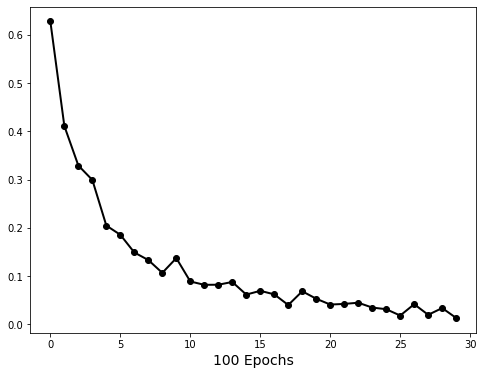

In [150]:
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(loss_record)),loss_record,'ko-',
          linewidth=2, markersize=6)

plt.xlabel("100 Epochs", size=14)

plt.show()

In [66]:
test_game_states = list( pickle.load( open( "test_game_states.p", "rb" ) ) )

In [67]:
boards = list(zip(*test_game_states))[0]
labels = list(zip(*test_game_states))[1]

In [68]:
cv_boards = boards[0:150000]
cv_labels = labels[0:150000]

test_boards = boards[150000:]
test_labels = labels[150000:]

In [69]:
X_cv = preprocess_boards(cv_boards)
y_cv = preprocess_labels(cv_labels)

In [151]:
y_pred = model(X_cv)
_, arg_max = torch.max(y_pred, dim = 1)
_, y_cv_arg_max = torch.max(y_cv, dim = 1)

In [152]:
torch.mean((arg_max== y_cv_arg_max).float() ).item()

0.993773341178894

In [153]:
bad_boards = X_cv[(arg_max!= y_cv_arg_max)]

In [137]:
bad_boards[0:10]

tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  1.,  1.,  0.,  0.,  0.],
          [ 0.,  1.,  1.,  0.,  1.,  1.,  0.],
          [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 1.,  1.,  0.,  1.,  0.,  0.,  1.]],

         [[-0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0., -1., -0., -1.],
          [-0., -0., -0., -1., -0., -0., -1.],
          [-1., -1., -1., -0., -1., -1., -1.],
          [-0., -0., -1., -0., -1., -1., -0.]]],


        [[[ 0.,  1.,  0.,  0.,  1.,  0.,  0.],
          [ 1.,  0.,  0.,  1.,  1.,  0.,  0.],
          [ 0.,  0.,  1.,  1.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  1.,  1.,  0.,  0.],
          [ 1.,  1.,  1.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  1.,  0.,  1.,  1.,  0.]],

         [[-0., -0., -0., -0., -0., -1., -1.],
          [-0., -1., -1., -0., -0., -1., -1.],
          [-1., -1., -0., -0., -1., -0., -0.],
     

In [154]:
bad_preds = y_pred[(arg_max!= y_cv_arg_max)]

In [142]:
seq = (torch.nn.Conv2d(in_channels = 2, out_channels = 128, kernel_size = 3, padding = 1), 
                        torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2, stride = 2),
                        torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2, padding = (0,1)), 
                        torch.nn.MaxPool2d(kernel_size = (2,4)))

def seq_check(seq, X_in):
    y = X_in
    print(y.shape)
    for layer in seq:
        y = layer(y)
        print(y.shape)
        
seq_check(seq, X[0:10])

torch.Size([10, 2, 6, 7])
torch.Size([10, 128, 6, 7])
torch.Size([10, 128, 3, 3])
torch.Size([10, 128, 2, 4])
torch.Size([10, 128, 1, 1])


In [158]:
bad_boards[5:10]


tensor([[[[ 0.,  0.,  0.,  0.,  1.,  1.,  0.],
          [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
          [ 1.,  1.,  0.,  0.,  0.,  1.,  1.],
          [ 1.,  0.,  0.,  0.,  1.,  0.,  1.],
          [ 1.,  0.,  0.,  0.,  1.,  0.,  1.]],

         [[-0., -1., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0., -1., -1., -1.],
          [-0., -1., -0., -0., -0., -1., -1.],
          [-0., -0., -0., -0., -1., -0., -0.],
          [-0., -1., -0., -0., -0., -1., -0.],
          [-0., -1., -1., -1., -0., -1., -0.]]],


        [[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
          [ 1.,  0.,  0.,  1.,  0.,  1.,  1.],
          [ 1.,  1.,  0.,  0.,  1.,  1.,  0.],
          [ 1.,  1.,  1.,  0.,  0.,  0.,  1.]],

         [[-1., -0., -0., -1., -0., -0., -0.],
          [-1., -0., -0., -1., -0., -0., -0.],
          [-1., -0., -0., -1., -1., -1., -0.],
     

In [157]:
bad_preds[5:10]

tensor([[4.3083e-01, 6.9683e-03, 5.6220e-01],
        [2.0321e-01, 9.3504e-05, 7.9670e-01],
        [3.8398e-01, 8.2595e-04, 6.1519e-01],
        [2.9592e-01, 7.0400e-01, 7.6874e-05],
        [4.6970e-01, 1.1853e-01, 4.1177e-01]], grad_fn=<SliceBackward>)

In [159]:
X_test = preprocess_boards(test_boards)
y_test = preprocess_labels(test_labels)

In [160]:
y_pred = model(X_test)
_, arg_max = torch.max(y_pred, dim = 1)
_, y_test_arg_max = torch.max(y_test, dim = 1)

In [161]:
torch.mean((arg_max== y_test_arg_max).float() ).item()

0.9935485124588013

In [ ]:
torch.save(model.state_dict(), '')